# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



# My Solution


## Introduction and Disclaimer
In the development of a winning strategy through the use of an ES approach, most of the difficulties have risen from the encoding of the problem in a convenient format. In the following, I have considered the already provided encoding and worked mostly on aspects and ideas related to ES. I have considered a candidate move `Nimply` as an individual, i.e. a `namedtuple` containing the row and the number of objects to remove. Subsequently I have tried to implemented a $(1, \lambda)$ strategy, reasoning as follows: after having applied a move (the opponent's one) the game (a `Nim` object) assumes a certain configuration. Starting from this, we can generate several offsprings to decide what will be the next move. This is a quite critical aspect since, in this game, all the topics related to goodness of a solution and fitness does not strictly depend on a single agent, but also on the behaviour of the opponent! Because of this, I was not actually able to create a pure evolution algorithm. Still, I tried to implement a strategy that wraps most of the aspects that are characteristic of these algorithms. I adopted a *comma* strategy since, in the definition of the problem, I have assigned no importance to the previous move; what matters is just the actual and the next. We can consider the **genotype** as the candidate move, and the **phenotype** as the actual configuration of the problem. Regarding the **fitness**, I was not able to find a decent measure of goodness that did not consider the *Nim-Sum*; the strategy I developed is quite an overkill with respect to the optimal strategy since it wins all the times except for some cases, and I assume this is due to the fact that precise (optimal) rules have been used. A way to make the algorithm more fair would have been to define a less powerful measure of fitness, but due to lack of time and due to the fact that I have worked alone on this Lab, I was not able to implement it respecting the deadline. For what does it concern the fixed rules strategy, I have assumed that `optimal` could already be considered as a very good one, so I used it as a benchmark when testing my solution. Since the last makes use of fixed rules as well, I assumed it could be considered as a sort of hybrid between the two approaches. But now stop grumbling and let's see how my strategy works!

## Methodology and Mutation
Let's say *Player0* plays using my strategy, and let's say *Player1* use an optimal one based on the *Nim-Sum*. As I have already anticipated, the choice of the next move from *Player0* will be dictated by the actual configuration of the game rather than his previous move. A smart agent should act on a space that is representative of the problem and, since *Player1* may have drastically changed it, it is necessary to take this into account. This is why a $(1, \lambda)$ strategy is needed: starting from the actual configuration of the problem, that has to be discarded in the next one, *Player0* generates a number of possible moves. It has to be noted that some of them could be illegal (!), e.g. removing a number of objects from a row greater than those available. These offsprings will be brutally killed and not considered as candidates in the following, replacing them with a legal configuration that keeps the same row and removes just one elements. How these offsprings are generated? Starting from the current configuration, a number of $\lambda$ candidate moves, depending on the actual configuration of the game, are created. Each of them acts on a random row, if at least one object does exist, and removes a random number of elements. The random value of the row is extracted from a Uniform, whereas the random number of objects to remove is extracted from a Poisson. **Why a Poisson? Why not a Gaussian?**. Let's consider a possible situation, e.g. 50 rows. First of all, notice that a Possion distribution tends to a Gaussian for high enough $\lambda$. Second, notice how it can only assume positive values (more convenient than the Gaussian) and that it becomes skewed when decreasing $\lambda$. This last aspect is fundamental, since, for small enough $\lambda$, the mutation will remove just a few number of objects from the row in a given configuration of the game; quite convenient if it is almost ended and just few objects are still to be removed. To model the behaviour of the $\lambda$, I have setted it equal to the average number of objects still present in the configuration; it naturally decreases during the game and, in the final stages, the ones that matter the most, it becomes more and more accurate. To speed up the game, *Player0* can randomly choose to adopt a *greedy* strategy in which he removes all the objects from the row that has the most in the actual configuration of the game. This is done with a certain probability that decrease along the game, and it is done in order to inject some randomicity that may actually helps in ending the game faster. Furthermore, in order to decrease the power of using the *Nim-Sum*, at every step only a random set of possible moves is considered, all randomly generated. 

## Fitness Function
To compute the `fitness` for the mutated resulting configurations, I have considered the *Nim-Sum*, reasoning as follows:

- `player_actual_advantage += 1`, if, at time `t`, the new configuration has `nim_sum == 0`,
- `opponent_future_advantage += 1`, if, at time `t + 1`, from the new configuration, the opponent can (*optimally*) reach a `nim_sum == 0`,
- `player_future_advantage += 1`, if, at time `t + 2`, once the opponent has (*optimally*) made the optimal move, the new configuration has (optimally) again `nim_sum == 0`.

- `player_actual_advantage += inf`, if, at time `t`, the new configuration has `sum(state.rows) == 1` (*Player0 wins*),
- `opponent_future_advantage += inf`, if, at time `t + 1`, from the new configuration, the opponent can (*optimally*) reach a `sum(state.rows) == 1` (*Player1 wins*).


For each `t`, the chosen move is the optimal one, i.e. the best possible move each Player can do. This strategy is called *Clairvoyant* because, at each step, the Player tries to read the next moves of the opponent. Finally, *Player0* choose from the pool the offspring with the highest fitness, i.e. the move that it is likely to induce a favourable present but also future configuration. Finally, the value of the fitness is given by the sum of the player advantages, from which the opponent advantage is subtracted.
 


In [209]:
import logging
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple
from copy import deepcopy
from pprint import pprint, pformat

%matplotlib inline

## The *Nim* and *Nimply* classes

In [44]:
Nimply = namedtuple("Nimply", "row, num_objects")

class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Functions

In [3]:
def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])    
    xor = tmp.sum(axis=0) % 2                                                   
    return int("".join(str(_) for _ in xor), base=2)                            


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)                               
        cooked["possible_moves"][ply] = nim_sum(tmp)    
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")

    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())

    ply = random.choice(spicy_moves)
    return ply


## Evolutionary Utils

In [7]:
def mutate(state: Nim) -> Nim:

    row_index = random.choice([index for index, value in enumerate(state.rows) if value != 0])
    multiverse = deepcopy(state)
    mut = np.random.poisson(np.mean(multiverse.rows) + 1)
    ply = Nimply(row_index, mut)
    
    if multiverse.rows[row_index] < mut :
        ply = Nimply(row_index, 1)
        return ply
    else:
        return ply

def fitness(state: Nim, move: Nimply) -> int:

    player_actual_advantage = 0
    player_future_advantage = 0
    opponent_future_advantage = 0
    multiverse = deepcopy(state)
    
    multiverse.nimming(move)

    if (nim_sum(multiverse) == 0):
        player_actual_advantage += 1

        if sum(multiverse.rows) == 1:
            return np.inf
        
        if sum(multiverse.rows) == 0:
            return -np.inf
    
    else:
                
        optimal_ply = optimal(multiverse)
        multiverse.nimming(optimal_ply)
        
        if sum(multiverse.rows) == 1:
            return -np.inf
        
        if sum(multiverse.rows) == 0:
            return np.inf

        elif nim_sum(multiverse) == 0:
        
            opponent_future_advantage += 1
            
            optimal_ply = optimal(multiverse)
            multiverse.nimming(optimal_ply)
            
            if sum(multiverse.rows) == 1:
                return np.inf

            elif nim_sum(multiverse) == 1:
                player_future_advantage += 1
    
    return player_actual_advantage + player_future_advantage - opponent_future_advantage


In [76]:
def pure_random(state: Nim) -> Nimply:
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0]) 
    num_objects = random.randint(1, state.rows[row])                    
    return Nimply(row, num_objects)

def gabriele(state: Nim) -> Nimply:
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]    
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))

def adaptive(state: Nim) -> Nimply:
    genome = {"love_small": 0.5}

def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())

    ply = random.choice(spicy_moves)
    return ply

def greedy(state: Nim) -> Nimply:

    most_objects_index = np.argmax([x for x in state.rows])
    return Nimply(most_objects_index, state.rows[most_objects_index])

def clairvoyant(state: Nim) -> Nimply:
    
    population = []
    universe = deepcopy(state)
    ply = Nimply(None, None)

    if sum(universe.rows) == 1:
        non_zero_row = [index for index, value in enumerate(universe.rows) if value != 0]
        return Nimply(non_zero_row[0], 1)
    
    else:
       
        for i in range(POPULATION_SIZE):
            
            multiverse = deepcopy(universe)
            mutation = mutate(multiverse)                       
            population.append((mutation, fitness(multiverse, mutation))) 
        
        best_index = np.argmax([x[1] for x in population])
        ply = population[best_index][0]
        if ply.num_objects == 0:
            ply = Nimply(ply.row, 1)
        clarity = 1 - 0.40 * (np.mean(universe.rows) / AVG)
        if random.random() >  clarity:
            ply = greedy(multiverse)

        return ply

In [ ]:
logging.getLogger().setLevel(logging.INFO)

strategy = (clairvoyant, optimal)

nim = Nim(7)
POPULATION_SIZE = 30

AVG = np.mean(nim.rows)
logging.info(f"init : {nim}")
player = 0

while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


In [206]:
winners_hyp = {}
size_list = [1, 2, 3, 5, 10, 15, 20, 25, 30, 40, 50, 100]

for size in size_list:

    POPULATION_SIZE = size
    winners = []

    for i in range(100):

        logging.getLogger().setLevel(logging.INFO)

        strategy = (clairvoyant, optimal)

        nim = Nim(10)

        AVG = np.mean(nim.rows)
        logging.info(f"init : {nim}")
        player = 0

        while nim:
            ply = strategy[player](nim)
            logging.info(f"ply: player {player} plays {ply}")
            nim.nimming(ply)
            logging.info(f"status: {nim}")
            player = 1 - player
        logging.info(f"status: Player {player} won!")
        winners.append(player)
    
    winners_hyp[str(POPULATION_SIZE)] = winners
    print(f'Win rate: {1 - sum(winners) / len(winners)}')

INFO:root:init : <1 3 5 7 9 11 13 15 17 19>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1)
INFO:root:status: <1 3 5 7 8 11 13 15 17 19>
INFO:root:ply: player 1 plays Nimply(row=6, num_objects=3)
INFO:root:status: <1 3 5 7 8 11 10 15 17 19>
INFO:root:ply: player 0 plays Nimply(row=9, num_objects=19)
INFO:root:status: <1 3 5 7 8 11 10 15 17 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 2 5 7 8 11 10 15 17 0>
INFO:root:ply: player 0 plays Nimply(row=8, num_objects=17)
INFO:root:status: <1 2 5 7 8 11 10 15 0 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=4)
INFO:root:status: <1 2 5 7 4 11 10 15 0 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=5)
INFO:root:status: <1 2 5 2 4 11 10 15 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=2)
INFO:root:status: <1 0 5 2 4 11 10 15 0 0>
INFO:root:ply: player 0 plays Nimply(row=6, num_objects=5)
INFO:root:status: <1 0 5 2 4 11 5 15 0 0>
INFO:root:ply: player 1 plays N

Win rate: 0.31999999999999995


INFO:root:status: <1 3 2 7 1 11 2 6 1 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=2)
INFO:root:status: <1 3 2 5 1 11 2 6 1 0>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=1)
INFO:root:status: <1 3 1 5 1 11 2 6 1 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <1 3 0 5 1 11 2 6 1 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=5)
INFO:root:status: <1 3 0 0 1 11 2 6 1 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=3)
INFO:root:status: <1 0 0 0 1 11 2 6 1 0>
INFO:root:ply: player 0 plays Nimply(row=5, num_objects=1)
INFO:root:status: <1 0 0 0 1 10 2 6 1 0>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=8)
INFO:root:status: <1 0 0 0 1 2 2 6 1 0>
INFO:root:ply: player 0 plays Nimply(row=8, num_objects=1)
INFO:root:status: <1 0 0 0 1 2 2 6 0 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=1)
INFO:root:status: <1 0 0 0 0 2 2 6 0 0>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INF

Win rate: 0.32999999999999996


INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <1 3 5 6 1 11 13 10 4 19>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 6 1 11 13 10 4 19>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=2)
INFO:root:status: <0 3 5 6 1 9 13 10 4 19>
INFO:root:ply: player 0 plays Nimply(row=9, num_objects=6)
INFO:root:status: <0 3 5 6 1 9 13 10 4 13>
INFO:root:ply: player 1 plays Nimply(row=8, num_objects=4)
INFO:root:status: <0 3 5 6 1 9 13 10 0 13>
INFO:root:ply: player 0 plays Nimply(row=6, num_objects=7)
INFO:root:status: <0 3 5 6 1 9 6 10 0 13>
INFO:root:ply: player 1 plays Nimply(row=9, num_objects=2)
INFO:root:status: <0 3 5 6 1 9 6 10 0 11>
INFO:root:ply: player 0 plays Nimply(row=5, num_objects=9)
INFO:root:status: <0 3 5 6 1 0 6 10 0 11>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 3 5 6 0 0 6 10 0 11>
INFO:root:ply: player 0 plays Nimply(row=6, num_objects=4)
INFO:root:status: <0 3 5 

Win rate: 0.39


INFO:root:status: <0 0 0 1 0 0 0 3 0 0>
INFO:root:ply: player 0 plays Nimply(row=7, num_objects=1)
INFO:root:status: <0 0 0 1 0 0 0 2 0 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0 0 0 0 0 0 2 0 0>
INFO:root:ply: player 0 plays Nimply(row=7, num_objects=1)
INFO:root:status: <0 0 0 0 0 0 0 1 0 0>
INFO:root:ply: player 1 plays Nimply(row=7, num_objects=1)
INFO:root:status: <0 0 0 0 0 0 0 0 0 0>
INFO:root:status: Player 0 won!
INFO:root:init : <1 3 5 7 9 11 13 15 17 19>
INFO:root:ply: player 0 plays Nimply(row=9, num_objects=19)
INFO:root:status: <1 3 5 7 9 11 13 15 17 0>
INFO:root:ply: player 1 plays Nimply(row=8, num_objects=11)
INFO:root:status: <1 3 5 7 9 11 13 15 6 0>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=8)
INFO:root:status: <1 3 5 7 1 11 13 15 6 0>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=8)
INFO:root:status: <1 3 5 7 1 3 13 15 6 0>
INFO:root:ply: player 0 plays Nimply(row=8, num_objects=5)
INFO:root:status: <

Win rate: 0.5


INFO:root:ply: player 0 plays Nimply(row=3, num_objects=4)
INFO:root:status: <1 2 1 3 7 0 2 4 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=2)
INFO:root:status: <1 0 1 3 7 0 2 4 0 0>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=2)
INFO:root:status: <1 0 1 3 5 0 2 4 0 0>
INFO:root:ply: player 1 plays Nimply(row=6, num_objects=2)
INFO:root:status: <1 0 1 3 5 0 0 4 0 0>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=2)
INFO:root:status: <1 0 1 3 3 0 0 4 0 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=3)
INFO:root:status: <1 0 1 3 0 0 0 4 0 0>
INFO:root:ply: player 0 plays Nimply(row=7, num_objects=1)
INFO:root:status: <1 0 1 3 0 0 0 3 0 0>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 0 1 3 0 0 0 3 0 0>
INFO:root:ply: player 0 plays Nimply(row=7, num_objects=1)
INFO:root:status: <0 0 1 3 0 0 0 2 0 0>
INFO:root:ply: player 1 plays Nimply(row=7, num_objects=2)
INFO:root:status: <0 0 1 3 0 0 0 0 0 0>
INFO:root:

Win rate: 0.6599999999999999


INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 2 4 7 9 5 13 15 17 19>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 2 4 7 9 5 13 15 17 19>
INFO:root:ply: player 0 plays Nimply(row=7, num_objects=13)
INFO:root:status: <0 2 4 7 9 5 13 2 17 19>
INFO:root:ply: player 1 plays Nimply(row=8, num_objects=17)
INFO:root:status: <0 2 4 7 9 5 13 2 0 19>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=7)
INFO:root:status: <0 2 4 7 2 5 13 2 0 19>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=2)
INFO:root:status: <0 2 4 7 2 3 13 2 0 19>
INFO:root:ply: player 0 plays Nimply(row=9, num_objects=19)
INFO:root:status: <0 2 4 7 2 3 13 2 0 0>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=3)
INFO:root:status: <0 2 4 7 2 0 13 2 0 0>
INFO:root:ply: player 0 plays Nimply(row=7, num_objects=1)
INFO:root:status: <0 2 4 7 2 0 13 1 0 0>
INFO:root:ply: player 1 plays Nimply(row=6, num_objects=13)
INFO:root:status: <0 2 4 7

Win rate: 0.63


INFO:root:ply: player 0 plays Nimply(row=6, num_objects=9)
INFO:root:status: <1 3 5 6 9 1 4 15 17 19>
INFO:root:ply: player 1 plays Nimply(row=8, num_objects=7)
INFO:root:status: <1 3 5 6 9 1 4 15 10 19>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 2 5 6 9 1 4 15 10 19>
INFO:root:ply: player 1 plays Nimply(row=7, num_objects=13)
INFO:root:status: <1 2 5 6 9 1 4 2 10 19>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=4)
INFO:root:status: <1 2 5 6 5 1 4 2 10 19>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=1)
INFO:root:status: <1 2 5 6 4 1 4 2 10 19>
INFO:root:ply: player 0 plays Nimply(row=9, num_objects=19)
INFO:root:status: <1 2 5 6 4 1 4 2 10 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=3)
INFO:root:status: <1 2 5 6 1 1 4 2 10 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=6)
INFO:root:status: <1 2 5 0 1 1 4 2 10 0>
INFO:root:ply: player 1 plays Nimply(row=7, num_objects=2)
INFO:root:status: <1 2 5 0 1 1

Win rate: 0.75


INFO:root:ply: player 0 plays Nimply(row=8, num_objects=17)
INFO:root:status: <1 3 1 7 9 11 13 15 0 0>
INFO:root:ply: player 1 plays Nimply(row=7, num_objects=5)
INFO:root:status: <1 3 1 7 9 11 13 10 0 0>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=1)
INFO:root:status: <1 3 0 7 9 11 13 10 0 0>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=4)
INFO:root:status: <1 3 0 7 9 7 13 10 0 0>
INFO:root:ply: player 0 plays Nimply(row=7, num_objects=4)
INFO:root:status: <1 3 0 7 9 7 13 6 0 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=4)
INFO:root:status: <1 3 0 7 5 7 13 6 0 0>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 0 7 5 7 13 6 0 0>
INFO:root:ply: player 1 plays Nimply(row=6, num_objects=4)
INFO:root:status: <0 3 0 7 5 7 9 6 0 0>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=4)
INFO:root:status: <0 3 0 7 1 7 9 6 0 0>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=6)
INFO:root:status: <0 3 0 7 1 1 9 6 

Win rate: 0.6799999999999999


INFO:root:ply: player 0 plays Nimply(row=9, num_objects=19)
INFO:root:status: <1 3 5 7 9 11 13 15 17 0>
INFO:root:ply: player 1 plays Nimply(row=6, num_objects=7)
INFO:root:status: <1 3 5 7 9 11 6 15 17 0>
INFO:root:ply: player 0 plays Nimply(row=8, num_objects=17)
INFO:root:status: <1 3 5 7 9 11 6 15 0 0>
INFO:root:ply: player 1 plays Nimply(row=6, num_objects=3)
INFO:root:status: <1 3 5 7 9 11 3 15 0 0>
INFO:root:ply: player 0 plays Nimply(row=7, num_objects=7)
INFO:root:status: <1 3 5 7 9 11 3 8 0 0>
INFO:root:ply: player 1 plays Nimply(row=6, num_objects=1)
INFO:root:status: <1 3 5 7 9 11 2 8 0 0>
INFO:root:ply: player 0 plays Nimply(row=5, num_objects=8)
INFO:root:status: <1 3 5 7 9 3 2 8 0 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=9)
INFO:root:status: <1 3 5 7 0 3 2 8 0 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=5)
INFO:root:status: <1 3 5 2 0 3 2 8 0 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <1 3 5 1 0 3 2 8 

Win rate: 0.71


INFO:root:ply: player 0 plays Nimply(row=9, num_objects=19)
INFO:root:status: <1 3 5 7 9 11 13 15 17 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=2)
INFO:root:status: <1 3 3 7 9 11 13 15 17 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 2 3 7 9 11 13 15 17 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <1 2 2 7 9 11 13 15 17 0>
INFO:root:ply: player 0 plays Nimply(row=8, num_objects=17)
INFO:root:status: <1 2 2 7 9 11 13 15 0 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=3)
INFO:root:status: <1 2 2 7 6 11 13 15 0 0>
INFO:root:ply: player 0 plays Nimply(row=7, num_objects=15)
INFO:root:status: <1 2 2 7 6 11 13 0 0 0>
INFO:root:ply: player 1 plays Nimply(row=6, num_objects=4)
INFO:root:status: <1 2 2 7 6 11 9 0 0 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=2)
INFO:root:status: <1 2 2 5 6 11 9 0 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=2)
INFO:root:status: <1 

Win rate: 0.88


INFO:root:ply: player 0 plays Nimply(row=9, num_objects=19)
INFO:root:status: <1 3 5 7 9 11 13 15 17 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=3)
INFO:root:status: <1 0 5 7 9 11 13 15 17 0>
INFO:root:ply: player 0 plays Nimply(row=8, num_objects=14)
INFO:root:status: <1 0 5 7 9 11 13 15 3 0>
INFO:root:ply: player 1 plays Nimply(row=7, num_objects=10)
INFO:root:status: <1 0 5 7 9 11 13 5 3 0>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=6)
INFO:root:status: <1 0 5 7 3 11 13 5 3 0>
INFO:root:ply: player 1 plays Nimply(row=5, num_objects=5)
INFO:root:status: <1 0 5 7 3 6 13 5 3 0>
INFO:root:ply: player 0 plays Nimply(row=6, num_objects=13)
INFO:root:status: <1 0 5 7 3 6 0 5 3 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=1)
INFO:root:status: <1 0 5 7 2 6 0 5 3 0>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 0 5 7 2 6 0 5 3 0>
INFO:root:ply: player 1 plays Nimply(row=7, num_objects=3)
INFO:root:status: <0 0 5 7 2 6

Win rate: 0.79


INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 2 5 7 9 11 13 15 17 19>
INFO:root:ply: player 1 plays Nimply(row=6, num_objects=7)
INFO:root:status: <1 2 5 7 9 11 6 15 17 19>
INFO:root:ply: player 0 plays Nimply(row=5, num_objects=8)
INFO:root:status: <1 2 5 7 9 3 6 15 17 19>
INFO:root:ply: player 1 plays Nimply(row=7, num_objects=10)
INFO:root:status: <1 2 5 7 9 3 6 5 17 19>
INFO:root:ply: player 0 plays Nimply(row=9, num_objects=19)
INFO:root:status: <1 2 5 7 9 3 6 5 17 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=8)
INFO:root:status: <1 2 5 7 1 3 6 5 17 0>
INFO:root:ply: player 0 plays Nimply(row=8, num_objects=17)
INFO:root:status: <1 2 5 7 1 3 6 5 0 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <1 2 5 6 1 3 6 5 0 0>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=6)
INFO:root:status: <1 2 5 0 1 3 6 5 0 0>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=1)
INFO:root:status: <1 2 5 0 0 3 

Win rate: 0.74


In [126]:
# winners_hyp = {}
# print(f'Win rate: {1 - sum(winners) / len(winners)}')

In [193]:
winners_hyp.keys()

dict_keys(['1', '2', '3', '5', '10', '15', '20', '25', '30', '40', '50', '100'])

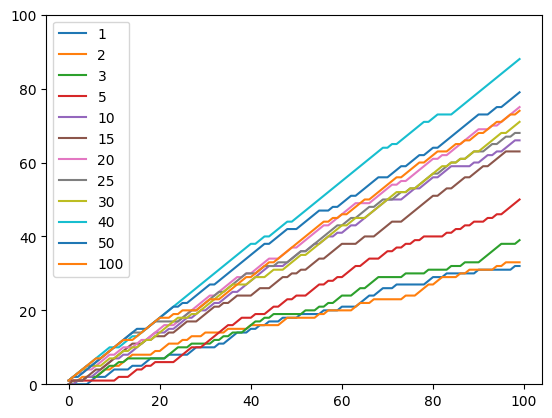

In [208]:
clair_win = 1 - np.array(winners)
for k, v in winners_hyp.items():
    plt.plot(range(100), np.cumsum(1 - np.array(v)), label = k)
plt.ylim(0, 100)
plt.legend()